# Overview

Greetings. This project as you have probably already inferred using your awesome powers of deduction and intellect involves the use of an Unsupervised Machine Learning Clustering model, the Gaussian Mixture Model. First of all though, what are we actually using this model on and why? 

This project will again involve the use of Additive Manufacturing data. Additive Manufacturing involves (in this case) creating bone implants using Titanium Alloys with the help of 3D Printing. This method is becoming increasingly popular, as it minimises waste material, and the components can also be customised to the patient in question, as everyone has their own unique bone dimensions. 

There is one caveat here however, pores. These are gaps in the material, and cause it to become structurally compromised, which is not what the fans came to see. These pores can be minimised through optimised process parameters, however they can't be removed entirely from the part. Different pores also cause more damage. Hence, it is important not only to quantify the amount of these defects, but also qualitatively determine what types of pores are present. Can you see where I'm going with this one yet? 

The best way currently to figure out what type of pores are present within the component, is to use CT Scans. These X-Rays penetrate into the component, detecting pores, and revealing a variety of geometric features on each pore (Volume, Surface Area, Roundness etc.). This is so smashing isn't it. However, the only issue here is that the frequency (so wavelength really) of the X-Rays places a lower bound on the minimum size of the detectable pores. So using this method we can only detect pores > resolution limit. 

To this end, we'll use another method. By taking a series of samples, slicing them in half, and then by getting high quality images, we can then get a good look at the exposed pores. This lets us see pores of all sizes. The drawback here, is that a small fraction of the total pores are seen using this method, it's labour intensive and time consuming, and destructive. 

## The Experiment:

So, what is special about what we're doing here. For this body of work, 3 different builds, of identical samples were created. Each build contained a grid of 77 Rods. The only difference between these builds was a process parameter, Gas Flow. This gas flow is needed to remove process by-products while the laser is melting samples, and generally it has an inverse relationship to the amount pores created, i.e. more gas less pores. The only reason its not as high as possible at all times is Argon gas is expensive. 

So, we have a manufacturers recomendation of 31 m$^{3}$ of gas per hour. One build was created at this flow, the Control. We also created a High sample set at 36  m$^{3}$, and a low at 26  m$^{3}$. These three sample sets were all X-CT scanned, and sectioned and imaged. We are now at the point where we can say we will use the Unsupervised GMM model, to cluster the porosity data into a known number of clusters, and take a look at how the gas flow rate affected the cluster proportions of each pore type. This cluster number was determined in a seperate notebook, using Bayesian Information Criterion (BIC) scores and was found to be 2. 

Now, just a brief intro into the XCT data, and Optical Microscopy data. Then finally a small bit on the GMM. 

## X-Ray CT Scan data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_xct = pd.read_csv('All_Pores_XCT.csv')
df_xct.sample(5)

,Unnamed: 0.1,Unnamed: 0,Diameter [mm],Equivalent diameter [mm],Volume [mm³],Voxel,Surface [mm²],Gap [mm],Compactness,Sphericity,...,Max. gray value,Mean gray value,Deviation of gray values,Label,Projected area (yz-plane) [mm²],Projected area (xz-plane) [mm²],Projected area (xy-plane) [mm²],AspectRatio,Rod,GasFlow
30962,30962,30962,0.17,0.07,0.0,76,0.03,0.25,0.06,0.52,...,14823,14289,326,4543,0.01,0.00,0.01,0.470588,41,low
63381,63381,63381,0.11,0.06,0.0,66,0.02,0.16,0.16,0.70,...,12090,11526,307,2130,0.00,0.00,0.01,0.727273,77,low
68417,68417,68417,0.14,0.07,0.0,88,0.02,-0.02,0.11,0.60,...,12133,11565,281,3422,0.01,0.01,0.01,0.666667,77,low
44972,44972,44972,0.17,0.08,0.0,118,0.04,0.01,0.10,0.51,...,14027,13162,414,5968,0.01,0.01,0.01,0.857143,64,low
80208,80208,80208,0.34,0.13,0.0,539,0.14,0.07,0.05,0.36,...,21822,20476,645,3292,0.03,0.02,0.03,0.566667,10,low


Above we see an example of the XCT data. There was less work to do here than for the optical microscopy data, only adding a rod number and Gas Flow column. Voxel here is analagous to a 3-dimensional pixel. We'll be reducing down the features used here, so no need to talk about them just yet!

## Optical Microscopy data

In [3]:
df_micrograph = pd.read_csv(r'C:\Users\conor\Documents\Python\Masters Python Files\Unsupervised Clustering\Allpores.csv')
df_micrograph = df_micrograph[['Area','Min','Max','Circ.','AR','Round','Solidity','Rod','Gas Flow']]
df_micrograph.sample(5)

,Area,Min,Max,Circ.,AR,Round,Solidity,Rod,Gas Flow
125984,11.302,255,255,1.000,1.069,0.936,0.875,25HMT,High
30637,8.061,255,255,1.000,1.553,0.644,0.909,21CTI,Control
6509,33.479,255,255,0.772,2.494,0.401,0.933,21LTI,Low
62621,1.639,255,255,1.000,1.000,1.000,1.000,37CBI,Control
71444,1.639,255,255,1.000,1.000,1.000,1.000,37CBI,Control


Above we can see an example of our micrograph tabular data. A bit of backstory here. So we had our sectioned images, as you can see below. By analysing these images using an image analysis software called ImageJ, which has a porosity analysis module included, we can obtain the above metrics per pore. 

What ImageJ does, is for a greyscale image (single colour channel), automatically assign a colour threshold, with pixels with a greyscale value larger considered as porosity and less than the threshold solid material. There is an element of subjectivity here but we'll assume this to be correct. The software then calculates the above measures for the pores. 

**Area :** The surface area of the exposed pore

**Min/Max :** The Min and Max Greyscale colour channel values within that pore

**Circ :** A measure or how irregular the pore is. Vaues approaching 1 indicate a perfectly circular pore. This is calculated with the following formula: $Circularity = 4 \pi \frac{ Area}{Perimeter^{2}}$

**AR :** Aspect Ratio indicates the Ratio of the maximum horizontal width of the pore to the maximum vertical height of the pore. Note these dimensions are in the plave of the sliced sample, so do not represent depth within the sample. 

**Roundness :** This is the inverse of the Aspect Ratio.

**Solidity :** This is the ratio of the pore area to its convex area. 

**Rod :** The sample from which the pore cam from.

**Gas Flow :** The Gas Flow from which the sample was made from. 

Note, more information on the ImageJ features can be found below at: 

https://imagej.net/ij/docs/menus/analyze.html

But now, a word from the sponsor of this project, the GMM Model. 

# Gaussian Mixture Model (GMM) 

So first of all, what is clustering? Clustering is a form of unsupervised Machine Learning, where the aim of the game is to group data into 'groups' or 'clusters', where data within a cluster is more similar to eahc other than to data in other clusters. The unsupervised part comes from the fact that clustering is an unsupervised machine learning form of modelling. This is where the data has no output value you are attempting to predict like regression modelling, no categorical value you are attempting to predict. You are simply attempting to see what parts of your dataset are similar to one another. 

The GMM model, is a probabilistic model, based on the underlying assumption that the dataset consists of several Gaussian distributions of unknown parameters. This is a particularily useful model for datasets such as ours, as it is a soft clustering model, in that a datapoint can belong to one or more clusters, and is only assigned to the cluster with the highest probability. 

See below, where we'll show what a distribution of two Gaussian two-dimensional distributions looks like:

In [4]:
# Set the mean and covariance
mean1 = [0, 0]
mean2 = [2, 0]
cov1 = [[1, .7], [.7, 1]]
cov2 = [[.5, .4], [.4, .5]]

# Generate data from the mean and covariance
data1 = np.random.multivariate_normal(mean1, cov1, size=1000)
data2 = np.random.multivariate_normal(mean2, cov2, size=1000)

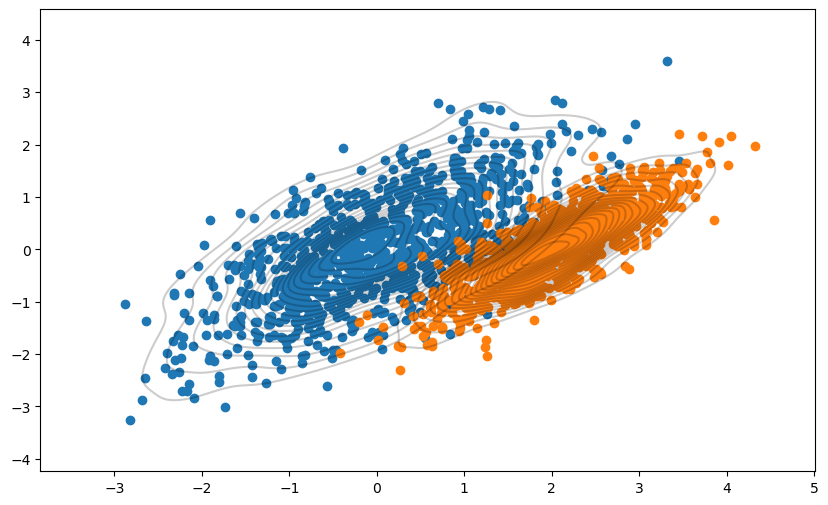

In [5]:
plt.figure(figsize=(10,6))

plt.scatter(data1[:,0],data1[:,1])
plt.scatter(data2[:,0],data2[:,1])

sns.kdeplot(x = data1[:, 0], y = data1[:, 1], levels=20, color='k', alpha=0.2)
sns.kdeplot(x = data2[:, 0],y =  data2[:, 1], levels=20, color='k', alpha=0.2)

plt.grid(False)
plt.show()

So above is an example where we definitely have Gaussian distributions. Each cluster has a mean, and covariances. GMM assumes this to be the case. Each datapoint in the above diagram would be assigned a lieklihood of belonging to each cluster, and the largest likelihood would be the cluster it would be assigned to. 

What are the mean and covariance I hear you think? The mean, simply put is the average value of all datapoints within the cluster. See how in our above example each mean is a 2x1 vector? This is because the mean has 2 dimensions in the graph. What is covariance? This is simply how two variables change with respect to one another. In the above example, we have a 2x2 Covariance matrix. The diagonal elements represent the variance of the x and y dimensions of the above distributions, while the off-diagonal elements represent how X changes with respect to Y. If these values are positive (Hint they are) this means an increase in one correlates to an increase in the other variable, and you can see this in the graph as it skews to the top right.

There has been a lot of babbling here, but we're nearly finished. Covariance is important in GMM, as it must be specified beforehand. It can either be Full, Tied, Diagonal and Spherical. Spherical indicates Off-Diagonal = 0, with Diagonal elements being equal meaning a circular gaussian distribution. In both Tied and Diagonal Covariance, the Gaussian distributions would be ellipsoids, however in tied the distributions must have the same minor and major axes. In Full it's a free for all, and shape, any direction. Mayhem and Ruckus. 

## How does the GMM do what it does? 

So, how does this work? Given that you have a number of clusters (We have, its 2 for both datasets) you supply this and the covariance type to the GMM Model. 

- 2 Gaussians are fit to the data, with randomly assigned means, covariances, and weights.
- **Expectation Maximization Algorithm** 
- **Expectation Step** The likelihood of each datapoint belonging to each cluster is then calculated.
- **Maximization Step** The parameters of the Gaussians are updated to maximise the likelihoods.
- This is iterated until convergence. This is when the likelihoods no longer increase drastically.
- The points are assigned to the cluster with the highest likelihoods. 

## Lets get this show on the road

In [6]:
low_xct = df_xct[df_xct['GasFlow'] == 'low']
control_xct = df_xct[df_xct['GasFlow'] == 'control']
high_xct = df_xct[df_xct['GasFlow'] == 'high']

In [7]:
low_om = df_micrograph[df_micrograph['Gas Flow'] == 'Low']
control_om = df_micrograph[df_micrograph['Gas Flow'] == 'Control']
high_om = df_micrograph[df_micrograph['Gas Flow'] == 'High']

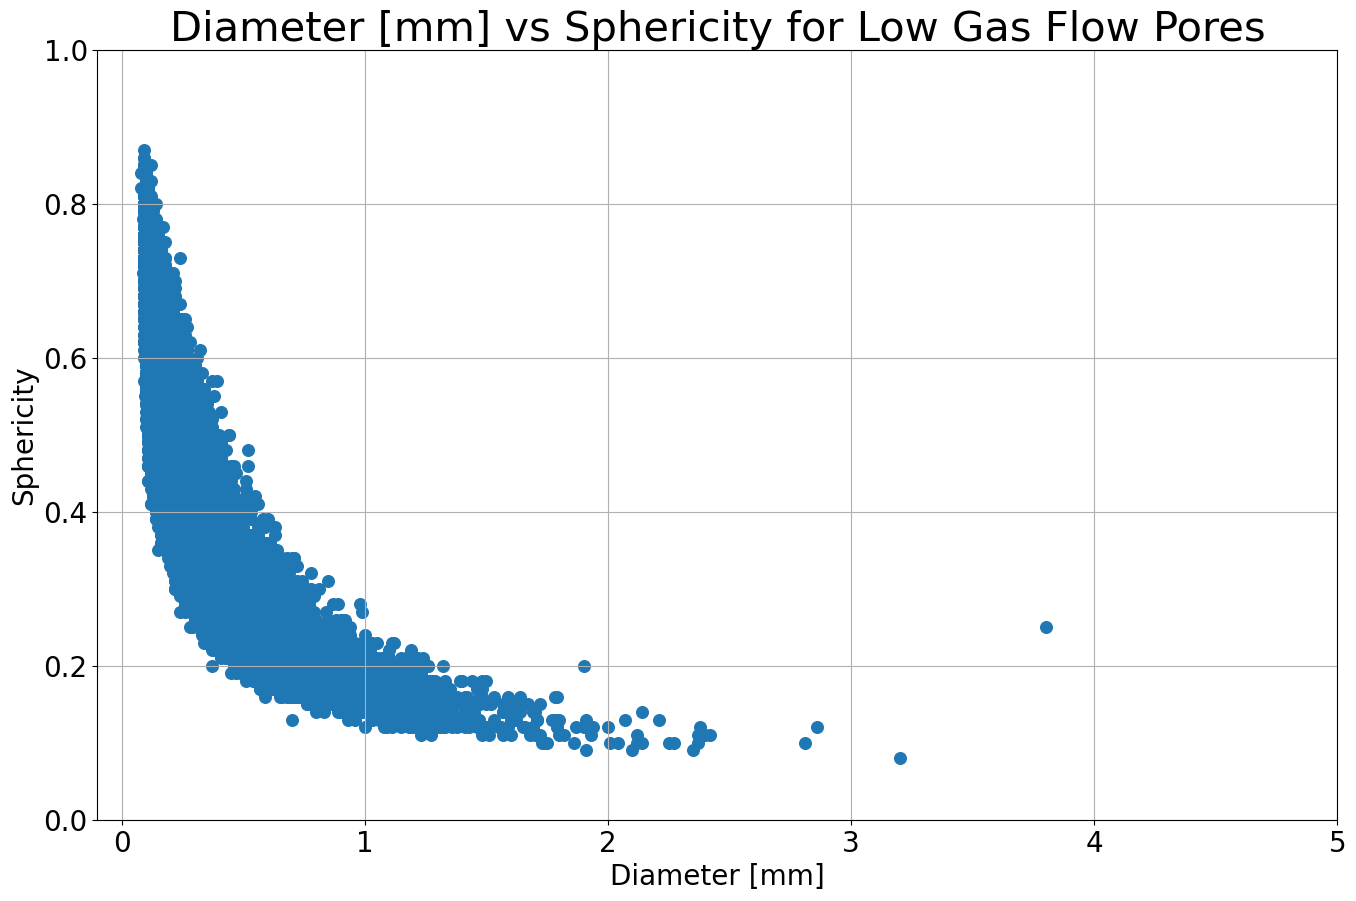

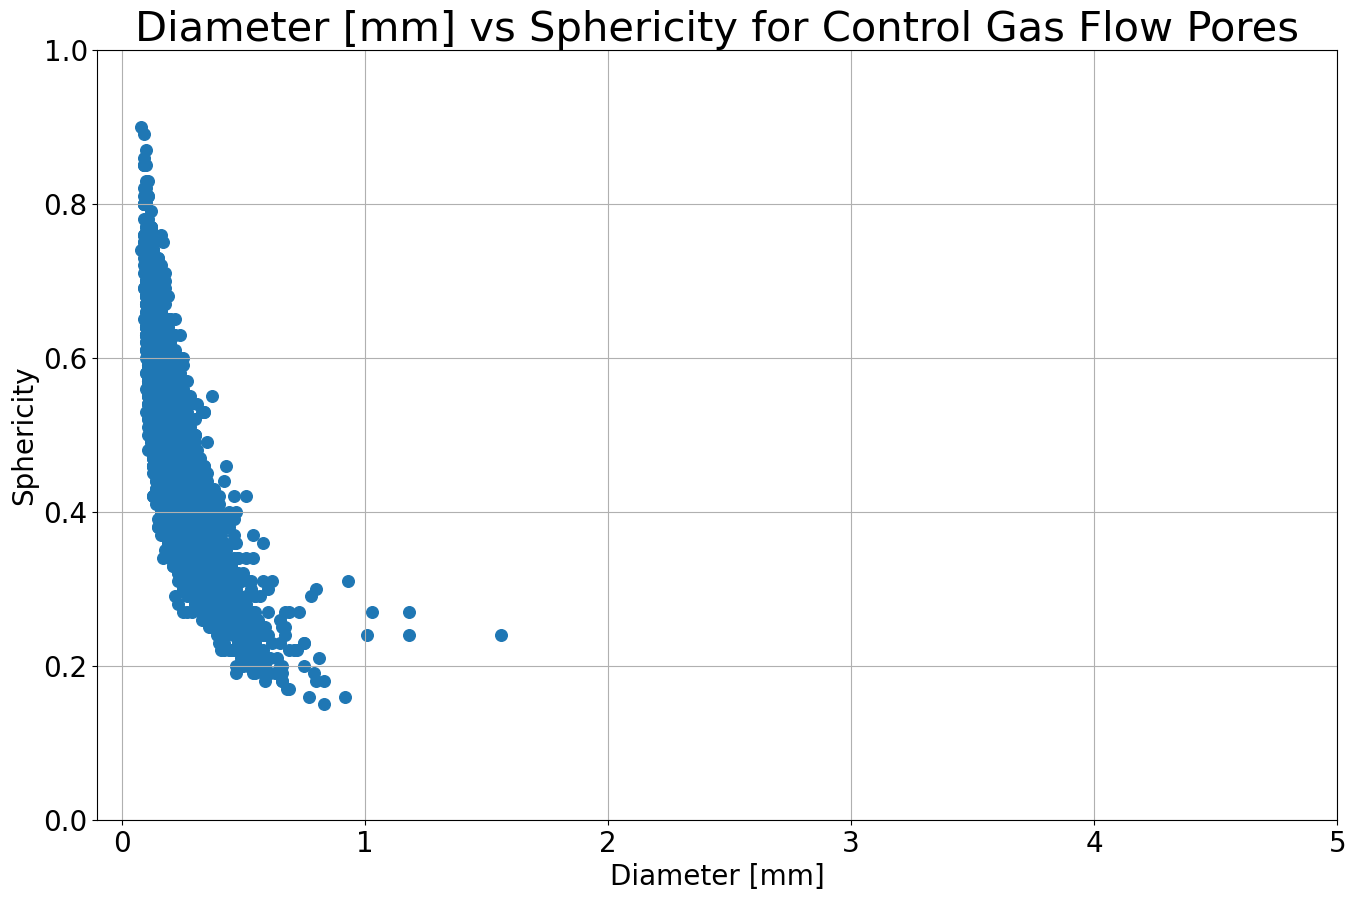

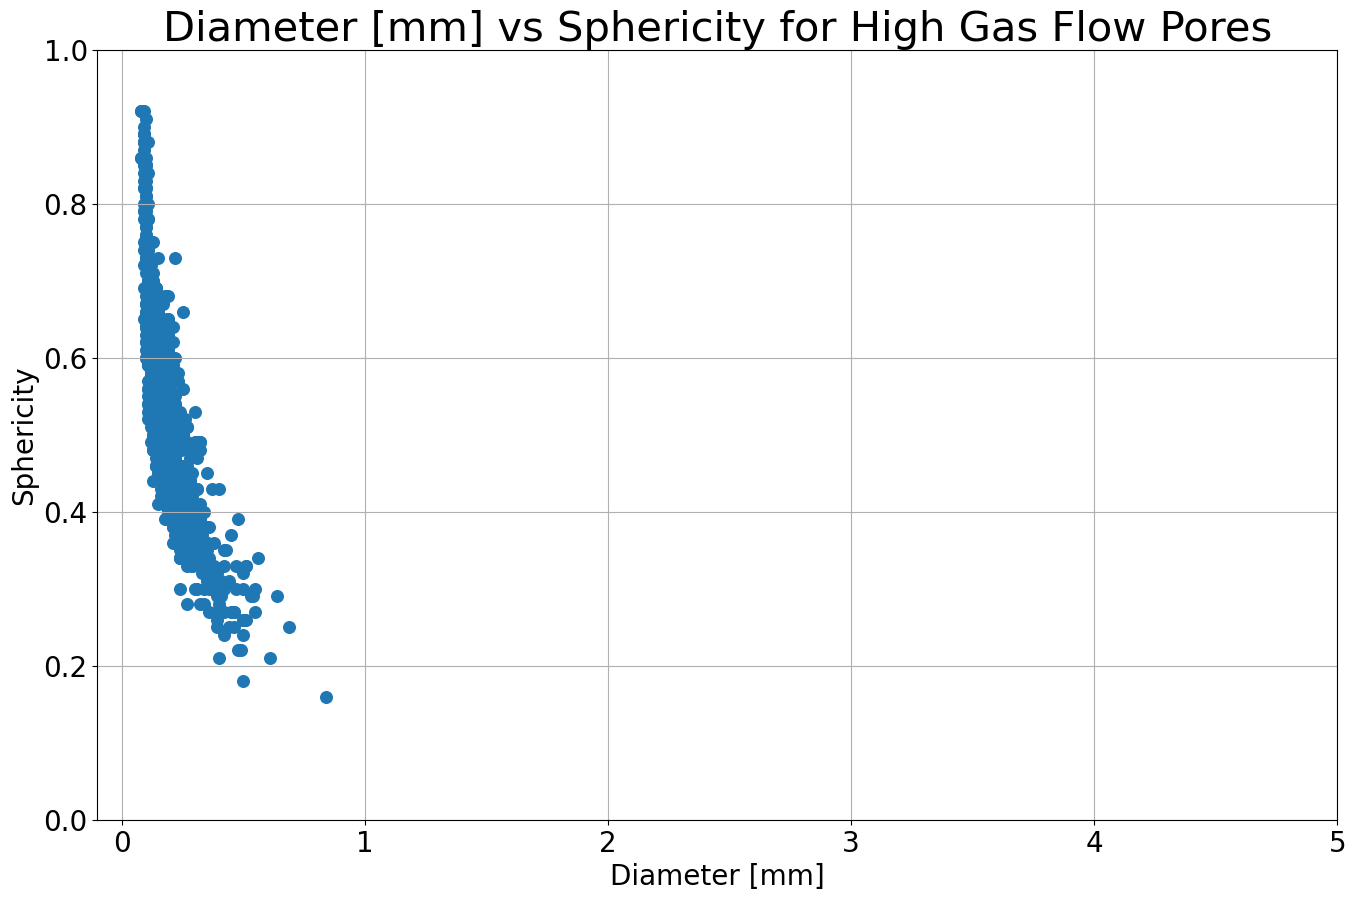

In [8]:
for i,j in zip([low_xct,control_xct,high_xct],['Low','Control','High']):
    ax1 = plt.scatter(x=i['Diameter [mm]'], y = i['Sphericity'],  linewidth = 1, zorder = 1, s = 70)
    plt.ylabel('Sphericity', fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    title = 'Diameter [mm] vs Sphericity for '+ j +' Gas Flow Pores'
    plt.title(title, fontsize = 30)
    plt.grid(axis = 'both', which = 'both')
    plt.xlabel('Diameter [mm]', fontsize = 20)
    plt.axis([-0.1,5,0.0,1])
    plt.gcf().set_size_inches(16,10)
    plt.show()

Well, before we even do anything we can see that the Low Gas Flow rate has more irregular, large pores. This was an expected result, as lower gas flow means less removal of by-products which in turn lends itself toward more drastic pores. These pores would tend to be keyhole, and lack of fusion pores, which we know from literature tend to occur due to incorrect process parameters (which we did oops). 

Now lets check the Microscope data

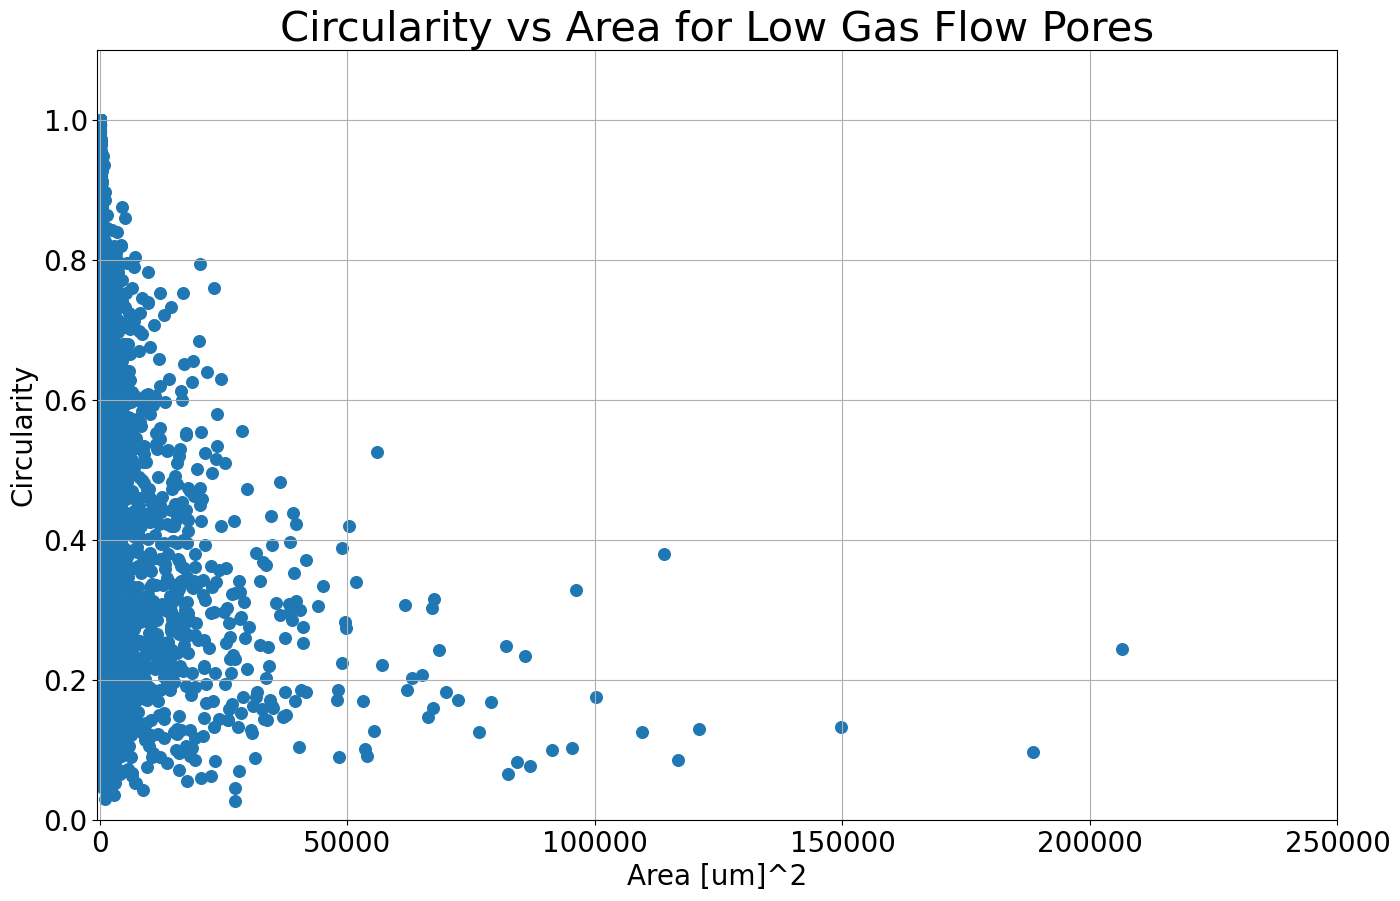

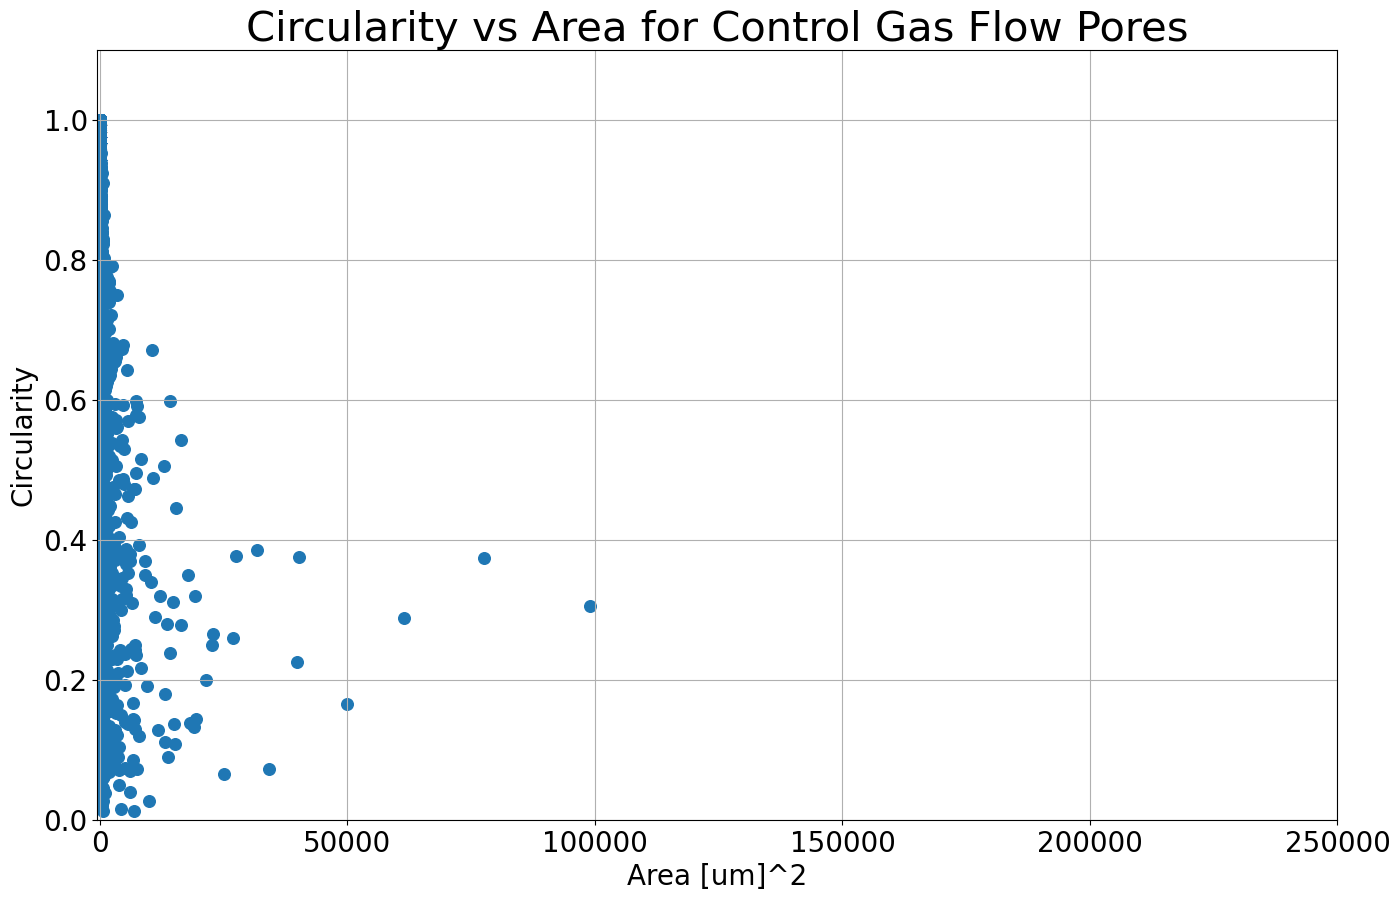

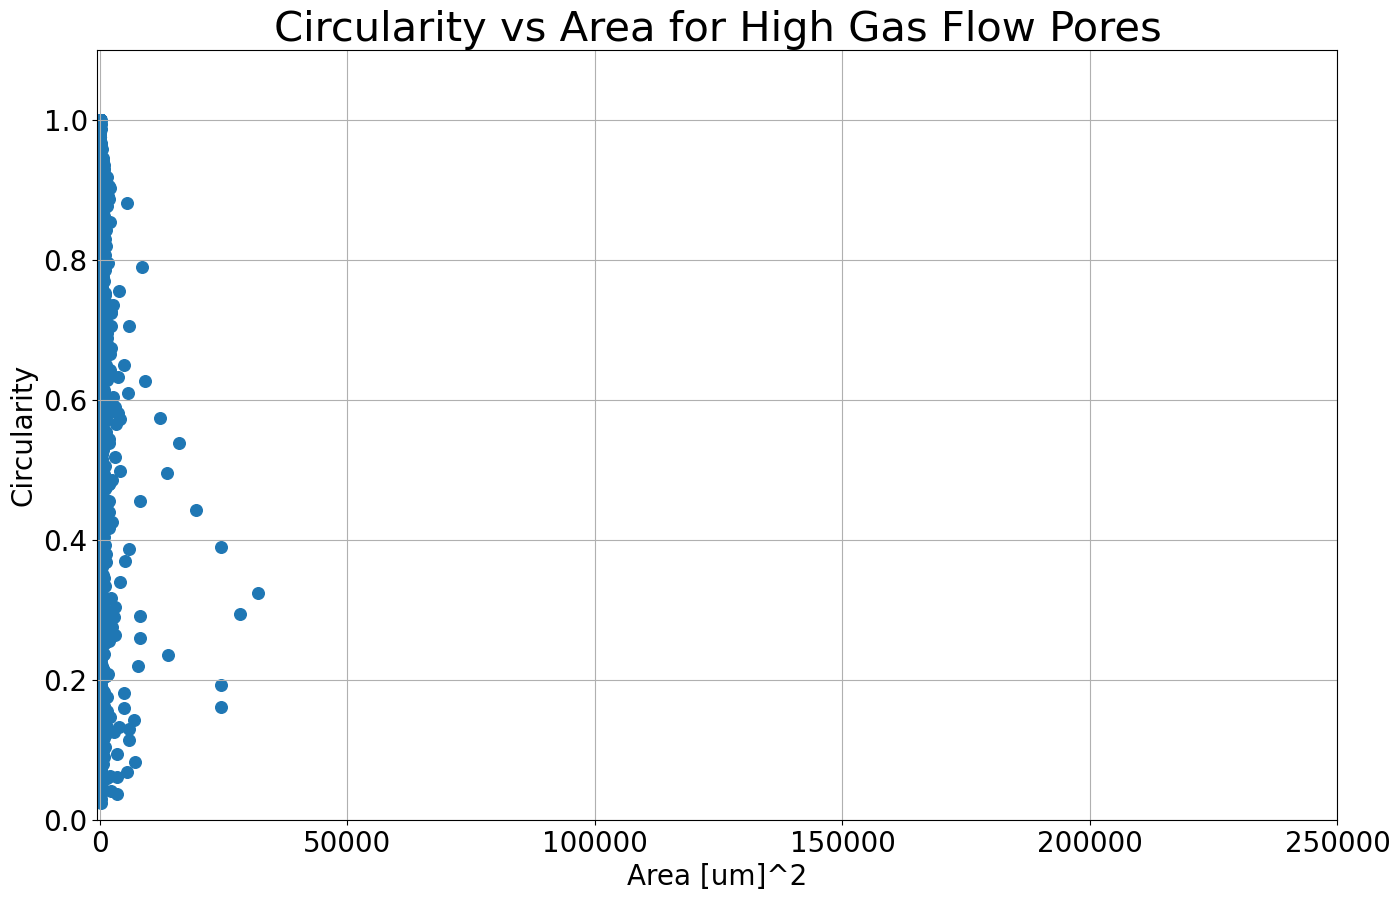

In [9]:
for i,j in zip([low_om,control_om,high_om],['Low','Control','High']):
    ax1 = plt.scatter(x=i['Area'], y = i['Circ.'],  linewidth = 1, zorder = 1, s = 70)
    plt.ylabel('Circularity', fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    title = 'Circularity vs Area for '+ j +' Gas Flow Pores'
    plt.title(title, fontsize = 30)
    plt.grid(axis = 'both', which = 'both')
    plt.xlabel('Area [um]^2', fontsize = 20)
    plt.axis([-500,250000,0.0,1.1])
    plt.gcf().set_size_inches(16,10)
    plt.show()

Oh my gosh, the same thing again. Almost as if the two techniques are looking at the same defects! Wowzers. Now, enough dossing. Let's get GMMing. 

In [10]:
#We had an excess of features here. We kept only the below features, as these are the most important when determining the type of pore. 
low_xct = low_xct[['Diameter [mm]', 'Voxel', 'Surface [mm²]', 'Compactness', 'Sphericity', 'Projected size z [mm]', 'AspectRatio']]
control_xct = control_xct[['Diameter [mm]', 'Voxel', 'Surface [mm²]', 'Compactness', 'Sphericity', 'Projected size z [mm]', 'AspectRatio']]
high_xct = high_xct[['Diameter [mm]', 'Voxel', 'Surface [mm²]', 'Compactness', 'Sphericity', 'Projected size z [mm]', 'AspectRatio']]

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn import mixture

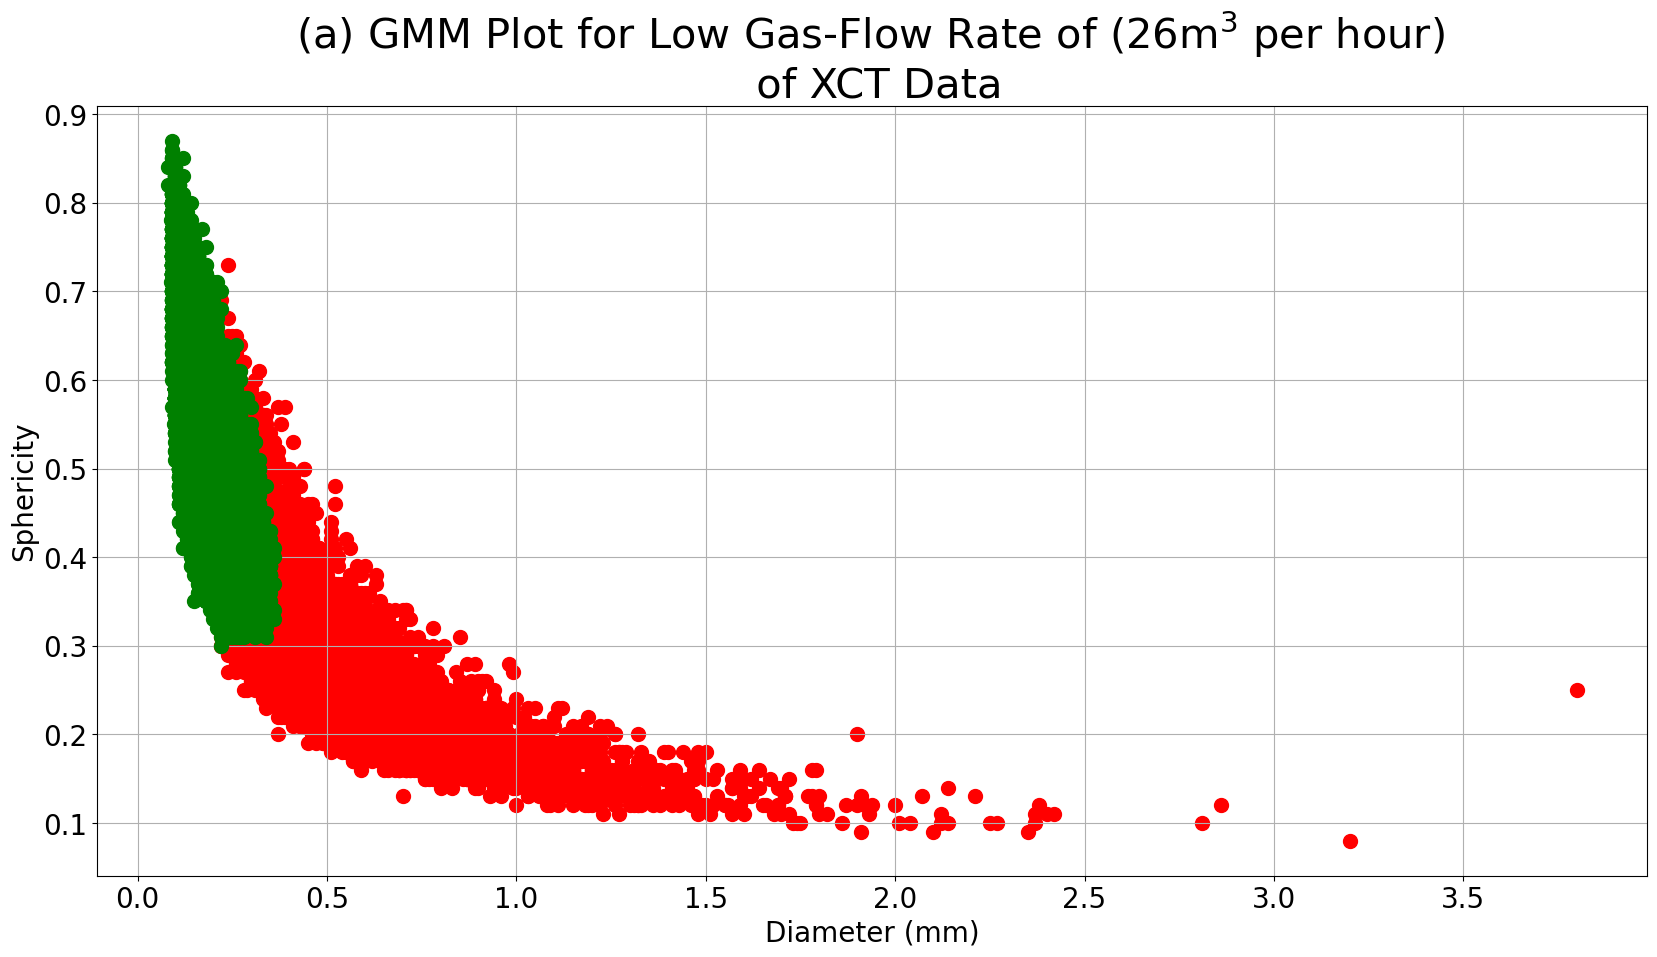

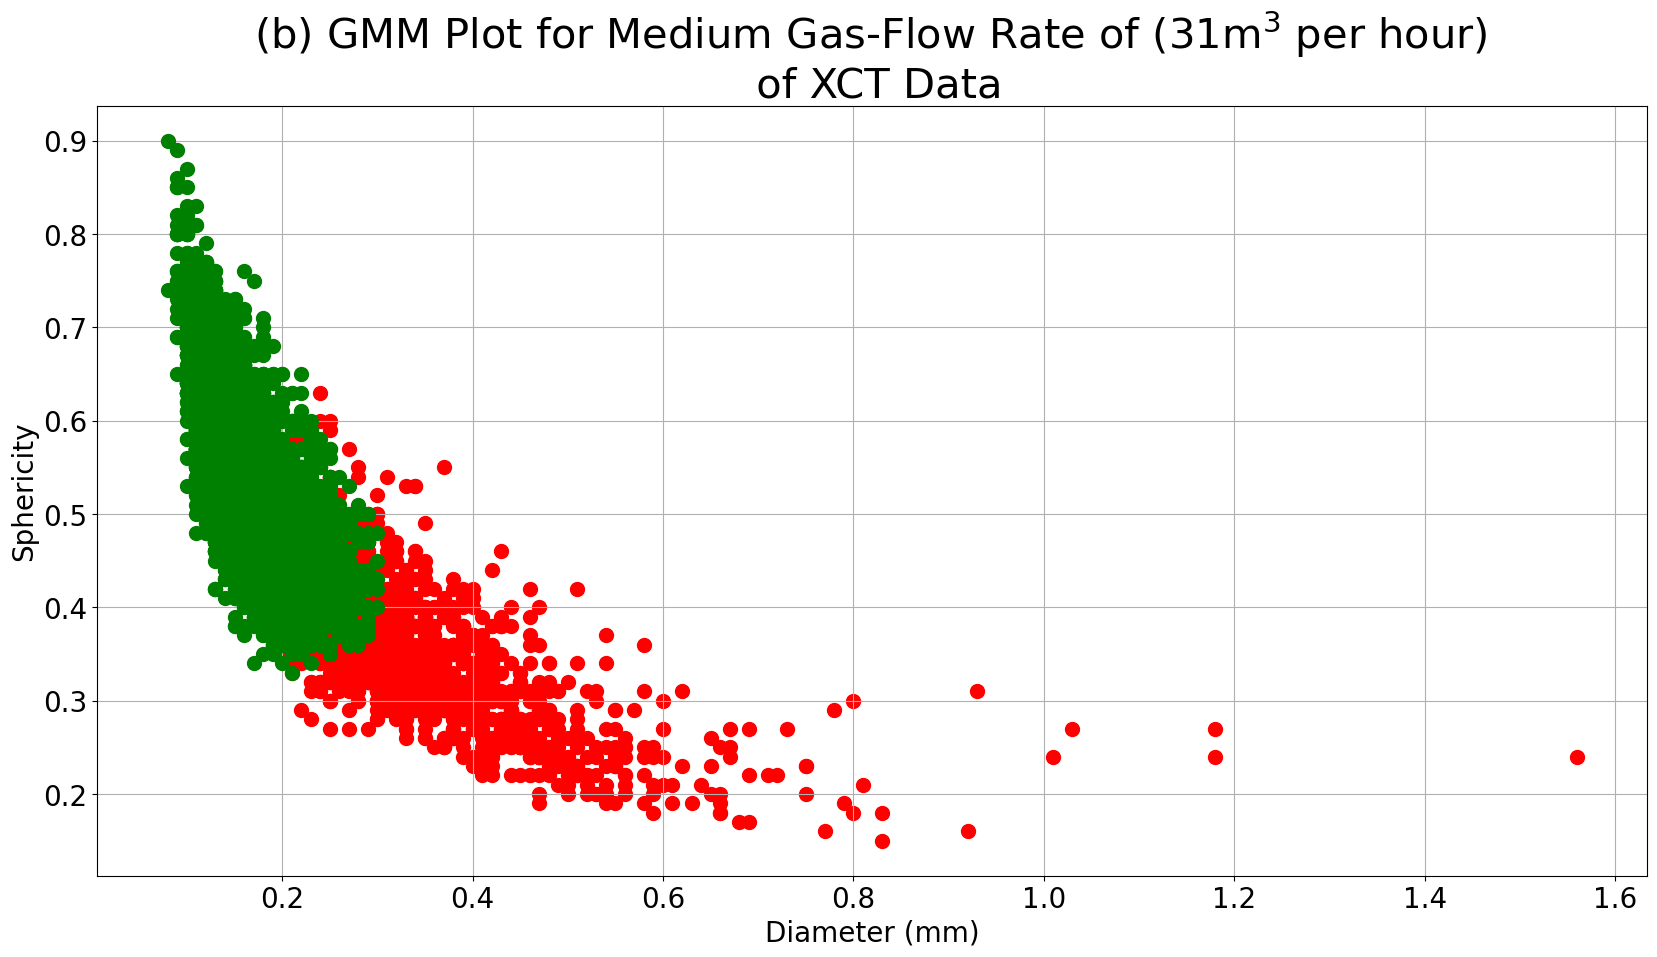

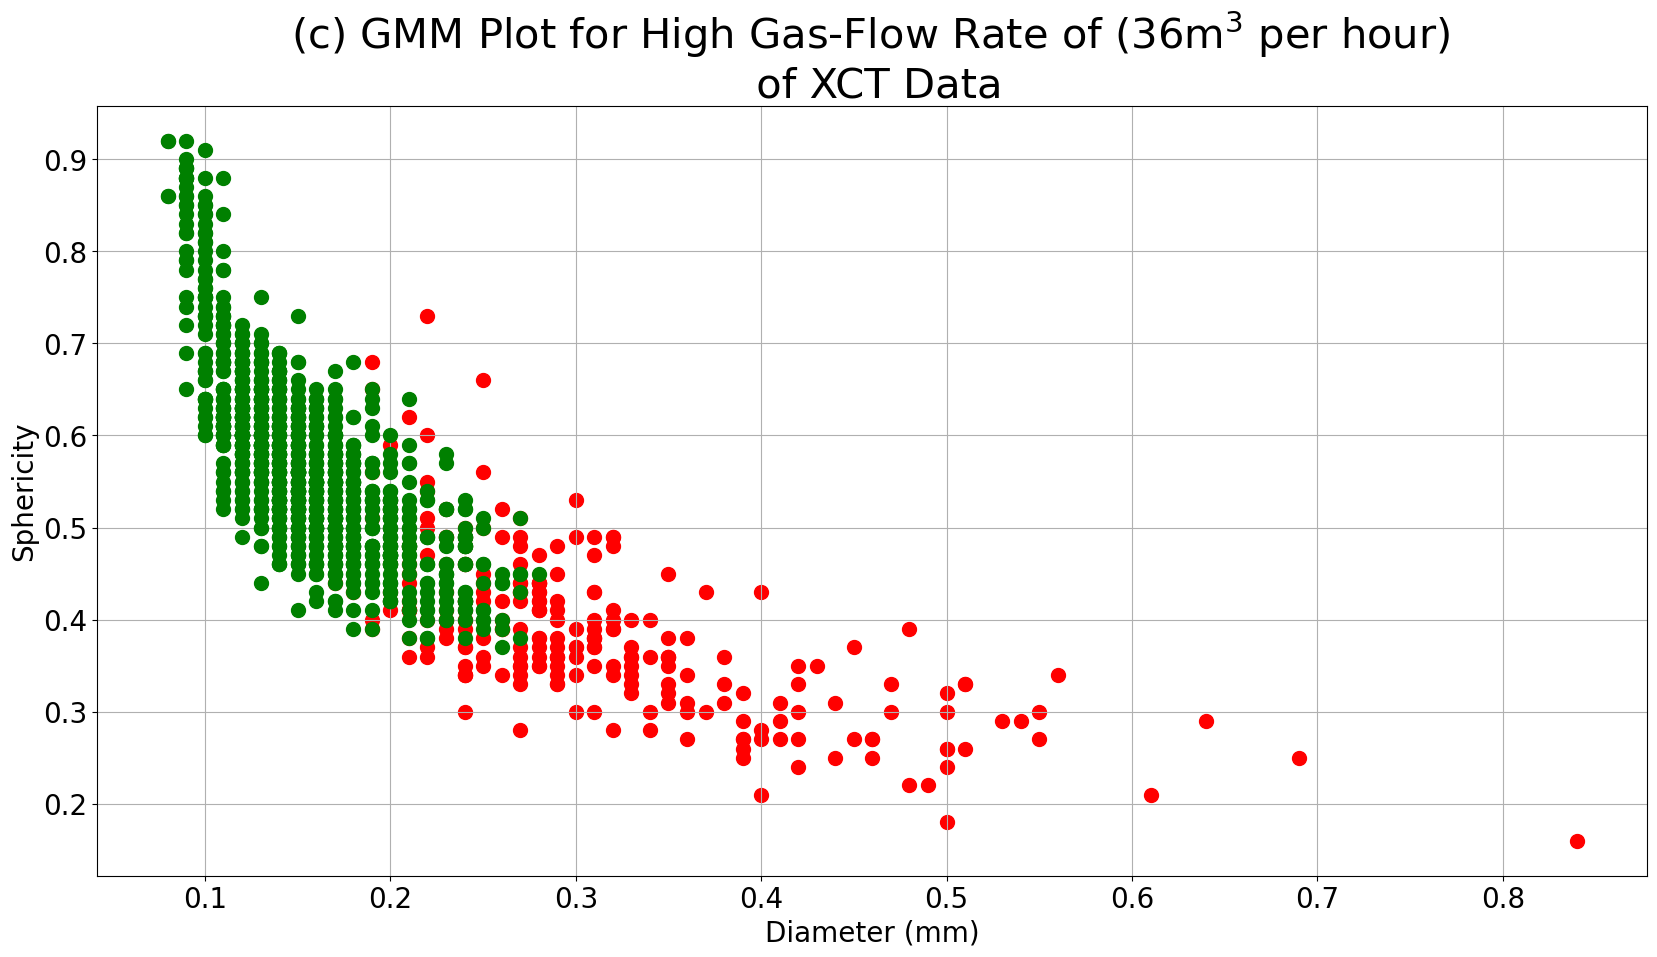

In [12]:
Gas_Flows = ['Low', 'Medium', 'High']
build_diagrams = ['(a)','(b)','(c)']
flow = ['(26m$^{3}$ per hour) ' , '(31m$^{3}$ per hour) ' , '(36m$^{3}$ per hour) ']
build_dataframes = [low_xct, control_xct, high_xct]
new_xct_df = []
for i,j,k,l in zip(build_dataframes,build_diagrams,Gas_Flows,flow):
    model = mixture.GaussianMixture(n_components=2, covariance_type='full')
    model = model.fit(i)
    labels = model.predict(i)
    temp_df = pd.DataFrame(i)
    temp_df['label'] = labels
    dummy_df1 = temp_df[temp_df['label'] == 0]
    dummy_df2 = temp_df[temp_df['label'] == 1]
    plt.scatter(y=dummy_df1['Sphericity'], x=dummy_df1['Diameter [mm]'], color='Green', linewidth = 1, zorder = 2, s = 100)
    plt.scatter(y=dummy_df2['Sphericity'], x=dummy_df2['Diameter [mm]'], color='Red', linewidth = 1, zorder = 1, s = 100)
    plt.ylabel('Sphericity', fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.title(j + ' GMM Plot for ' + k + ' Gas-Flow Rate of ' + l + '\n of XCT Data', fontsize = 30)
    plt.grid(axis = 'both', which = 'both')
    plt.xlabel('Diameter (mm)', fontsize = 20)
    plt.gcf().set_size_inches(20,10)
    #plt.legend([ 'Gas', 'Non-Gas'], loc= 'upper right',prop={'size': 26})
    plt.show()
    new_xct_df.append(pd.concat([dummy_df1,dummy_df2]))

OK, so we've split the data from each Gas Flow rate into two seperate clusters. These are evident per flow in the above graph. What is now needed however, is some understanding of the above results. 

There is one cluster, of much smaller diameter, with a larger sphericity. These would indicate more Gas type porosity. This is some insider knowledge here. These pores form when an excess of purging gas becomes entrapped within the molten material, and leaves bubble like pores within the finished component. Figuring as these form due to an excess of gas, you would think that the High gas flow rate, should have the highest proportion of this cluster in comparison to the other two shouldn't it? We'll check that in a smidgeon. Note that we're looking at proportions here, as the low build had much more porosity than the control, which in turn had so much more than the high. 

### Correction

See how we produced two clusters per gas flow in the above Cell? After much thinking, a lot of troubled thought, and even more frowning, I have decided this is not the way we are going to proceed. We are going to apply clustering to the entire dataset. My reasoning:

By applying clustering to each gas flow, we are forcing 2 clusters to appear in each Gas Flow rate. While this seems OK, I don't think it is. We want to see how those cluster proportions change with Gas Flow rate. By applying this per gas flow, we are forcing there to be 2 clusters per flow rate, when in actuality this may not be the case for the extremes (High Gas Flow for example may be entirely Gas pores). 

It may actually help us by using more data to train a singular model also, in place of three smaller models using less training data per model. 

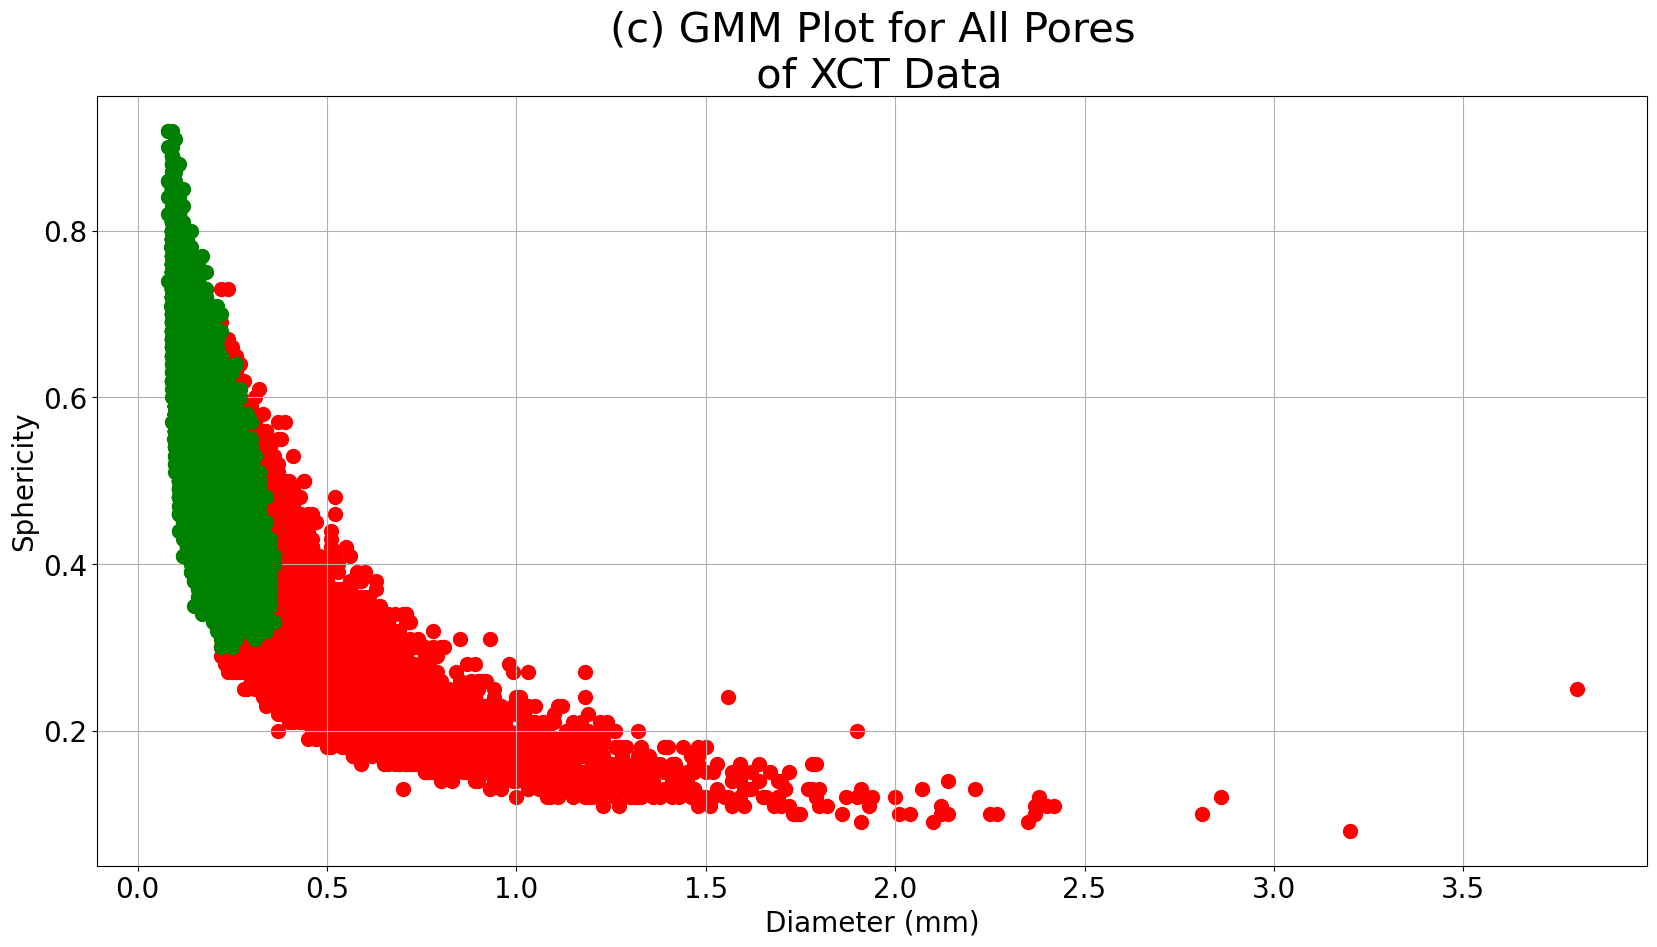

In [13]:
#Performing some jiggery pokery 
Gas_Flow_labels = df_xct['GasFlow']
df_xct = df_xct[['Diameter [mm]', 'Voxel', 'Surface [mm²]', 'Compactness', 'Sphericity', 'Projected size z [mm]', 'AspectRatio']]
#Applying the GMM again
model = mixture.GaussianMixture(n_components=2, covariance_type='full')
model = model.fit(df_xct)
labels = model.predict(df_xct)
temp_df = pd.DataFrame(df_xct)
temp_df['label'] = labels
dummy_df1 = temp_df[temp_df['label'] == 0]
dummy_df2 = temp_df[temp_df['label'] == 1]
plt.scatter(y=dummy_df1['Sphericity'], x=dummy_df1['Diameter [mm]'], color='Green', linewidth = 1, zorder = 2, s = 100)
plt.scatter(y=dummy_df2['Sphericity'], x=dummy_df2['Diameter [mm]'], color='Red', linewidth = 1, zorder = 1, s = 100)
plt.ylabel('Sphericity', fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.title(j + ' GMM Plot for All Pores' +  '\n of XCT Data', fontsize = 30)
plt.grid(axis = 'both', which = 'both')
plt.xlabel('Diameter (mm)', fontsize = 20)
plt.gcf().set_size_inches(20,10)
plt.show()

Now what we need to do, is to reassign the Gas Flow column, and analyse what got clustered to where. 

In [14]:
#Reassigning the Gas Flows
temp_df['Gas Flow'] = Gas_Flow_labels
#Seeing which cluster corresponds to cluster groups 0 and 1 
print('The average feature values for cluster group 0 are :' + '\n')
print(np.mean(temp_df[temp_df['label'] == 0].iloc[:,:-2], axis = 0))
print('The average feature values for cluster group 1 are :' + '\n')
print(np.mean(temp_df[temp_df['label'] == 1].iloc[:,:-2], axis = 0))

The average feature values for cluster group 0 are :

Diameter [mm]              0.174957
Voxel                    152.338291
Surface [mm²]              0.042080
Compactness                0.110436
Sphericity                 0.522661
Projected size z [mm]      0.111596
AspectRatio                1.064290
dtype: float64
The average feature values for cluster group 1 are :

Diameter [mm]               0.436594
Voxel                    1272.882011
Surface [mm²]               0.314647
Compactness                 0.055024
Sphericity                  0.315628
Projected size z [mm]       0.259971
AspectRatio                 1.083788
dtype: float64


We can therfore see from the above that Cluster 0 is the smaller, more regular porosity. 

So, to name these clusters. We know that in the literature, there are 3 classes of pores: Lack of Fusion, Keyhole, and Gas type. However, we have two clusters, and cannot definitively what cluster is a combination of 2 of those classes. We will as a result get simplistic with it, and name our clusters **Regular** and **Irregular**. Regular most likely being a combination of Gas & Keyhole pores, with Irregular being majority Lack of Fusion type pores. 

Let's apply our new names, rather than 0 and 1, and finally once and for all see how Gas flow affects these clusters. 

In [15]:
#Low Gas Flow
Low_Gas_Flow_Regular = round(len(temp_df[(temp_df['Gas Flow'] == 'low') & (temp_df['label'] == 0)]) / len(temp_df[(temp_df['Gas Flow'] == 'low') ]),3)
print(f'The portion of pores belonging to the Regular Cluster in the Low Gas Flow is {Low_Gas_Flow_Regular} and the the portion of Irregular Pores is {round(1 - Low_Gas_Flow_Regular,3)}')
#Control Gas Flow
Control_Gas_Flow_Regular = round(len(temp_df[(temp_df['Gas Flow'] == 'control') & (temp_df['label'] == 0)]) / len(temp_df[(temp_df['Gas Flow'] == 'control') ]),3)
print(f'The portion of pores belonging to the Regular Cluster in the Control Gas Flow is {Control_Gas_Flow_Regular} and the the portion of Irregular Pores is {round(1 - Control_Gas_Flow_Regular,3)}')
# High Gas Flow
High_Gas_Flow_Regular = round(len(temp_df[(temp_df['Gas Flow'] == 'high') & (temp_df['label'] == 0)]) / len(temp_df[(temp_df['Gas Flow'] == 'high') ]),3)
print(f'The portion of pores belonging to the Regular Cluster in the High Gas Flow is {High_Gas_Flow_Regular} and the the portion of Irregular Pores is {round(1 - High_Gas_Flow_Regular,3)}')

The portion of pores belonging to the Regular Cluster in the Low Gas Flow is 0.779 and the the portion of Irregular Pores is 0.221
The portion of pores belonging to the Regular Cluster in the Control Gas Flow is 0.842 and the the portion of Irregular Pores is 0.158
The portion of pores belonging to the Regular Cluster in the High Gas Flow is 0.895 and the the portion of Irregular Pores is 0.105


## Conclusion 

Holy smokes, this is groundbreaking stuff. As we had initially thought, the proportion of pores that are grouped in the 'Regular' increases with Gas Flow rate, as we can see in the above. 

This result is fairly intuitive, as although we cannot say directly that Regular pores are Gas pores, they do share the exact same geometrical characteristics, so therefore it is likely that this is the case. More gas = more gas defects. Eureka. It is interesting to note that the increase in cluster proportion is fairly linear with respect to gas flow rate. Each time the flow rate increased 5m$^{3}$ per hour, the proportion went up 0.063 and 0.053. We'll say roughly linear lol. 

Now to see if this same trend occurs in the microscopy data.  

## Optical Microscopy Check 

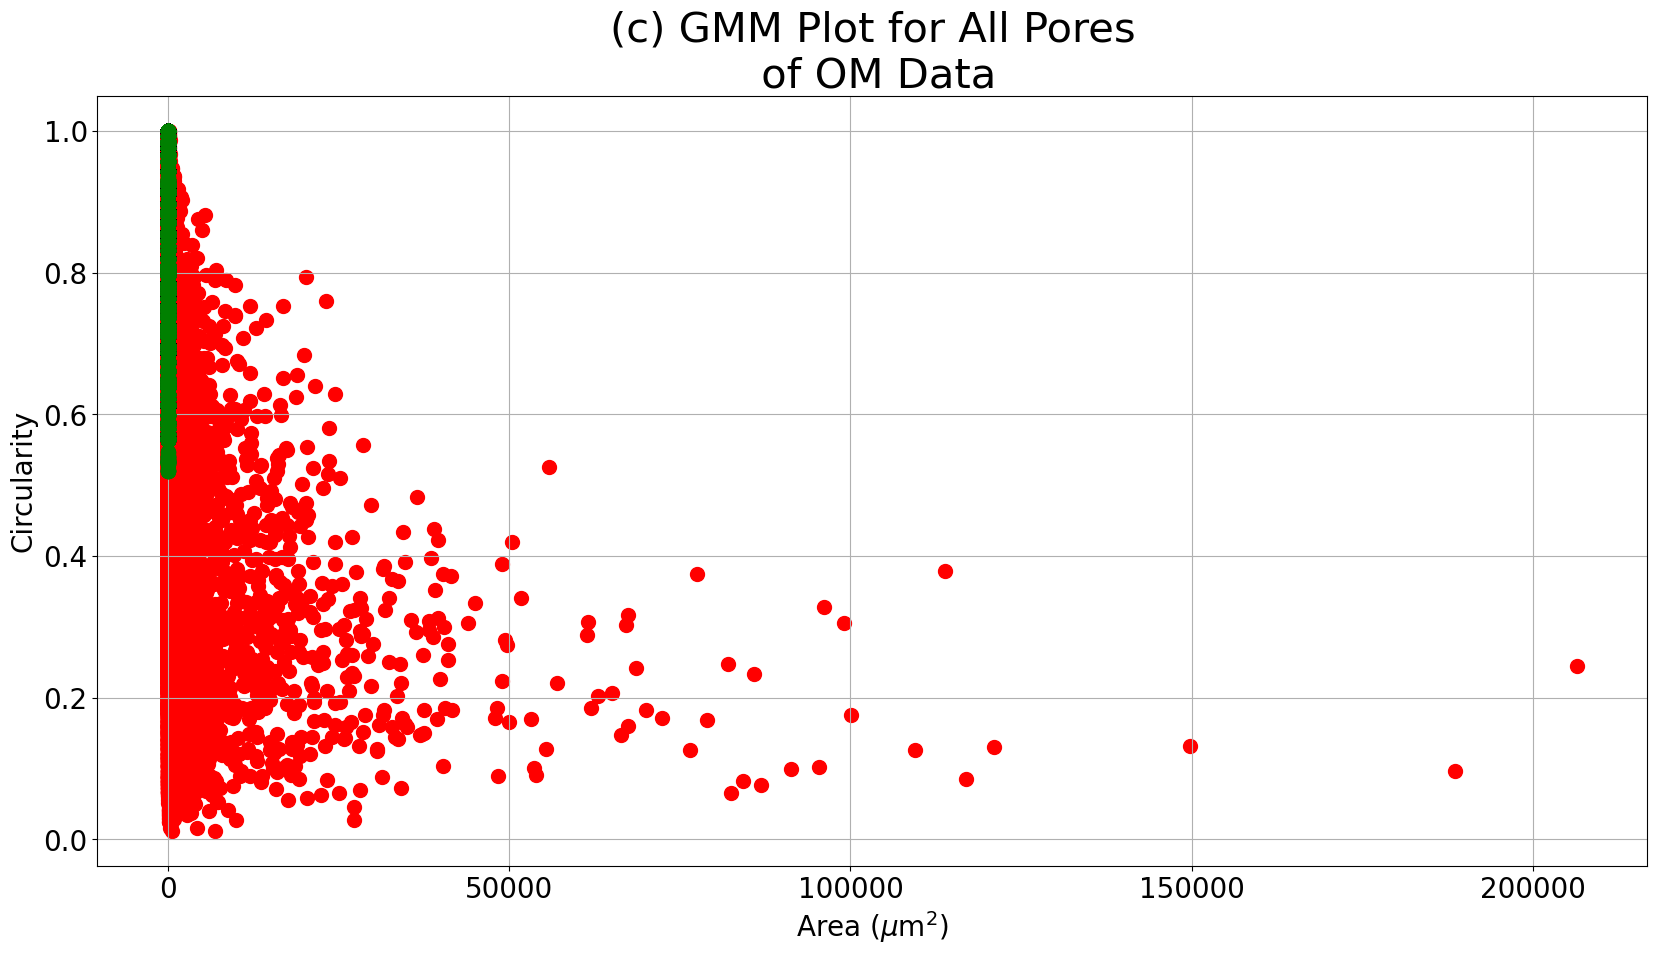

In [16]:
#Performing some jiggery pokery 
Gas_Flow_labels = df_micrograph['Gas Flow']
df_micrograph = df_micrograph[['Area', 'Circ.', 'AR', 'Round', 'Solidity']]
#Applying the GMM again
model = mixture.GaussianMixture(n_components=2, covariance_type='full')
model = model.fit(df_micrograph)
labels = model.predict(df_micrograph)
temp_df = pd.DataFrame(df_micrograph)
temp_df['label'] = labels
dummy_df1 = temp_df[temp_df['label'] == 0]
dummy_df2 = temp_df[temp_df['label'] == 1]
plt.scatter(y=dummy_df1['Circ.'], x=dummy_df1['Area'], color='Green', linewidth = 1, zorder = 2, s = 100)
plt.scatter(y=dummy_df2['Circ.'], x=dummy_df2['Area'], color='Red', linewidth = 1, zorder = 1, s = 100)
plt.ylabel('Circularity', fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.title(j + ' GMM Plot for All Pores' +  '\n of OM Data', fontsize = 30)
plt.grid(axis = 'both', which = 'both')
plt.xlabel('Area ($\mu$m$^{2}$)', fontsize = 20)
plt.gcf().set_size_inches(20,10)
plt.show()

In [17]:
#Reassigning the Gas Flows
temp_df['Gas Flow'] = Gas_Flow_labels
#Seeing which cluster corresponds to cluster groups 0 and 1 
print('The average feature values for cluster group 0 are :' + '\n')
print(np.mean(temp_df[temp_df['label'] == 0].iloc[:,:-2], axis = 0))
print('The average feature values for cluster group 1 are :' + '\n')
print(np.mean(temp_df[temp_df['label'] == 1].iloc[:,:-2], axis = 0))

The average feature values for cluster group 0 are :

Area        5.231763
Circ.       0.961417
AR          1.571885
Round       0.725768
Solidity    0.939547
dtype: float64
The average feature values for cluster group 1 are :

Area        684.826580
Circ.         0.546357
AR            2.859986
Round         0.477551
Solidity      0.735096
dtype: float64


Twinning, cluster 0 was for Regular pores in both examples.

In [18]:
#Low Gas Flow
Low_Gas_Flow_Regular = round(len(temp_df[(temp_df['Gas Flow'] == 'Low') & (temp_df['label'] == 0)]) / len(temp_df[(temp_df['Gas Flow'] == 'Low') ]),3)
print(f'The portion of pores belonging to the Regular Cluster in the Low Gas Flow is {Low_Gas_Flow_Regular} and the the portion of Irregular Pores is {round(1 - Low_Gas_Flow_Regular,3)}')
#Control Gas Flow
Control_Gas_Flow_Regular = round(len(temp_df[(temp_df['Gas Flow'] == 'Control') & (temp_df['label'] == 0)]) / len(temp_df[(temp_df['Gas Flow'] == 'Control') ]),3)
print(f'The portion of pores belonging to the Regular Cluster in the Control Gas Flow is {Control_Gas_Flow_Regular} and the the portion of Irregular Pores is {round(1 - Control_Gas_Flow_Regular,3)}')
# High Gas Flow
High_Gas_Flow_Regular = round(len(temp_df[(temp_df['Gas Flow'] == 'High') & (temp_df['label'] == 0)]) / len(temp_df[(temp_df['Gas Flow'] == 'High') ]),3)
print(f'The portion of pores belonging to the Regular Cluster in the High Gas Flow is {High_Gas_Flow_Regular} and the the portion of Irregular Pores is {round(1 - High_Gas_Flow_Regular,3)}')

The portion of pores belonging to the Regular Cluster in the Low Gas Flow is 0.576 and the the portion of Irregular Pores is 0.424
The portion of pores belonging to the Regular Cluster in the Control Gas Flow is 0.862 and the the portion of Irregular Pores is 0.138
The portion of pores belonging to the Regular Cluster in the High Gas Flow is 0.721 and the the portion of Irregular Pores is 0.279


OK, this is much uglier. I had hoped to see the same trend in this dataset too. However, using the Optical Microscopy data also has its limitations: 

- The use of ImageJ, and the porosity analysis module may have introduced some errors. This could be due to incorrect pixel thresholding when determining was was actually porous, and what was noise.

- The destructive method used to section the samples may have mechanically introduced pores through abrasion. These would not be due to the process, and could be skewing the GMM models learning.

- Microstructural defects in the images could also have skewed the model results. 